# Introduction
This notebook created by Sakali Katerina, within the courses of subject eBusiness and the Information System Lab of the University of Macedonia. The purpose was to have hands-on experience in Python and practise further our skills to Machine Learning and Data Science.

The notebook has been created to be used in a RAPIDS environment. In particular, it has been developed in a 16 vCPUs, 6O GB RAM and 1 NVIDIA Tesla T4 GPU in Google Cloud Platform.

# The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to predict which previously purchased products will be in a user’s next order.

# 1. Import and Reshape Data
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

# 1.1 Import the required packages

In [12]:
# Import packages
import pandas as pd
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
import gc
gc.enable()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# 1.2 Load data from the CSV files
Loading data from Instacart's CSV Files which we have to load into Python.

We first unzip the .zip file downloaded from Kaggle.

In [13]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [14]:
orders = pd.read_csv('input/orders.csv' )
order_products_train = pd.read_csv('input/order_products__train.csv')
order_products_prior = pd.read_csv('input/order_products__prior.csv')
products = pd.read_csv('input/products.csv')
aisles = pd.read_csv('input/aisles.csv')
departments = pd.read_csv('input/departments.csv')

The following DataFrames are:
* orders: This table includes all orders, namely prior, train, and test. It has single primary key (order_id).
* order_products_train: This table includes training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* order_products_prior : This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* products: This table includes all products. It has a single primary key (product_id)
* aisles: This table includes all aisles. It has a single primary key (aisle_id)
* departments: This table includes all departments. It has a single primary key (department_id)

In [15]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [16]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [17]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [18]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [19]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [20]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


# 1.3 Reshape data
We transform the data in order to facilitate their further analysis. First, we convert character variables into categories so we can use them in the creation of the model. In Python, a categorical variable is called category and has a fixed number of different values.

In [21]:
# Reshape data - Converting character variables into category 
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')

# 1.4 Create a DataFrame (op)
with the orders and the products that have been purchased on prior orders.

Note: The new DataFrame (op) includes only prior orders 

In [22]:
# Merge of orders and order_products_prior
op = orders.merge(order_products_prior, on = 'order_id', how = 'inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


# 2. Create Predictor Variables
Identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:

* User predictors describing the behavior of a user e.g. total number of orders of a user.
* Product predictors describing characteristics of a product e.g. total number of times a product has been purchased.
* User & product predictors describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

# 2.1 Create user predictors
**2.1.1 Number of orders per customer**

In [23]:
user = op.groupby('user_id')[['order_number']].max()
user.columns = ['user_total_orders']
user = user.reset_index()
user.head()

,user_id,user_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


**2.1.2 How frequent a customer has reordered products**

A ratio which shows for each user to what extent has products have been reordered in the past

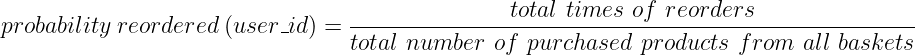

In [24]:
user_reorder = op.groupby('user_id')[['reordered']].mean()
user_reorder.columns = ['user_reordered_ratio']
user_reorder = user_reorder.reset_index()
user_reorder.head()

,user_id,user_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [25]:
# Merge of user and user_reorder DataFrame
user = user.merge(user_reorder, on='user_id', how='left')
user.head()

,user_id,user_total_orders,user_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [26]:
# Delete the user_reorder DataFrame
del user_reorder
gc.collect()

154

# 2.2 Create product predictors
**2.2.1 Number of purchases for each product**

We calculate the total number of purchases for each product (from all customers)

In [27]:
prd = op.groupby('product_id')[['order_id']].count()
prd.columns = ['product_total_purchases']
prd = prd.reset_index()
prd.head()

,product_id,product_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


**2.2.2 What is the probability for a product to be reordered**

In this section we want to find the products which have the highest probability of being reordered. 

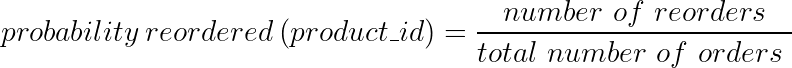

Also, we are going to remove all the products that have less than 40 purchases in order the calculation of the ratio to be meaningful.

In [28]:
# The probability for a product to be reordered
# Remove products with less than 40 purchases & calculate the mean of reorders

product_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
product_reorder = product_reorder.groupby('product_id')[['reordered']].mean()
product_reorder.columns = ['product_reorder_ratio']
product_reorder = product_reorder.reset_index()
product_reorder.head()

,product_id,product_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [29]:
# Merge of prd and product_reorder DataFrame
prd = prd.merge(product_reorder, on='product_id', how='left')

# Filling out NaN values
prd['product_reorder_ratio'] = prd['product_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,product_total_purchases,product_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


In [30]:
# Delete the product_reorder DataFrame
del product_reorder
gc.collect()

88

# 2.3 Create user-product predictors
**2.3.1 How many times a user bought a product**

In [31]:
usxpr = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('usxpr_total_bought')
usxpr = usxpr.reset_index()
usxpr.head()

,user_id,product_id,usxpr_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


**2.3.2 How frequently a customer bought a product after its first purchase**

This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to a buy it (starting from her first purchase of the product):

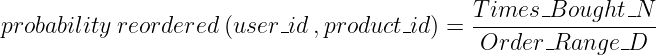

* Times_Bought_N = Times a user bought a product
* Order_Range_D = Total orders placed since the first user's order of a product

For examble: we examine the use with user_id: 1 and the product with product_id: 13032. User 1 has made 10 orders in total. She has bought the product 13032 for first time in her 2nd order and she has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from her 2nd order until her last order). As a result, she has bought it 3 out of 9 times, meaning reorder_ratio=3/9= 0,333.

The Order_Range_D variable is created using two supportive variables:

* Total_orders = Total number of orders of each user
* First_order_number = The order number where the customer bought a product for first time

So, in the next blocks we create:

* The numerator 'Times_Bought_N'
* The denumerator 'Order_Range_D' with the use of the supportive variables 'total_orders' & 'first_order_number'
* Our ratio 'usxpr_order_ratio'


In [32]:
# How frequently a customer bought a product after its first purchase - 'Times_Bought_N'
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [33]:
# Calculate the denumerator - 'Order_Range_D'
total_orders = op.groupby('user_id')[['order_number']].max()
total_orders.columns = ['total_orders']
total_orders = total_orders.reset_index()
total_orders.head()

,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [34]:
# Calculate the order number where the user bought a product for first time - 'first_order_number'
first_order_n = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_n = first_order_n.reset_index()
first_order_n.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [35]:
# Merge of first_order_n with the total_orders DataFrame and the creation of 'Order_Range_D'
span = pd.merge(total_orders, first_order_n, on='user_id', how='right')
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [36]:
# Create the final ratio 'usxpr_reorder_ratio'
usxpr_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
usxpr_ratio['usxpr_reorder_ratio'] = usxpr_ratio.Times_Bought_N / usxpr_ratio.Order_Range_D
usxpr_ratio = usxpr_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
usxpr_ratio.head()

,user_id,product_id,usxpr_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [37]:
# Delete temporary DataFrames
del times, first_order_n, span
gc.collect()

88

In [38]:
# Merge of usxpr and usxpr_ratio DataFrame
usxpr = usxpr.merge(usxpr_ratio, on=['user_id', 'product_id'], how='left')
usxpr.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


In [39]:
# Delete of usxpr_ratio DataFrame
del usxpr_ratio
gc.collect()

44

**2.3.3 How many times a customer bought a product on its last 5 orders**

For this feature, we want the last five orders for each customer and get how many times bought any product on them.

We need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last five orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.
* Create the following ratio:

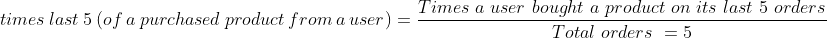

In [40]:
# Variable order_number_back
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10


In [41]:
# Keep only the last five orders for each customer
op5 = op[op.order_number_back <= 5]
op5.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
29,3367565,1,prior,6,2,7,19.0,196,1,1,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,5
33,550135,1,prior,7,1,9,20.0,196,1,1,4


In [42]:
# How many times each customer bought a product
last_five = op5.groupby(['user_id','product_id'])['order_id'].count().to_frame('last5_times')
last_five.head()

last5_times
user_id product_id             
1       196                   5
        10258                 5
        12427                 5
        13032                 2
        25133                 5

In [43]:
# Merge of last_five and usxpr DataFrame - Filling out NaN values
usxpr = usxpr.merge(last_five, on=['user_id', 'product_id'], how='left')
usxpr = usxpr.fillna(0)
usxpr.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,0.0
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


In [44]:
# Delete op5 and last_five DataFrames
del op5 , last_five
gc.collect()

110

In [45]:
# Merge of usxpr and user DataFrame. Store the results on a new DataFrame - data
data = usxpr.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio
0,1,196,10,1.000000,5.0,10,0.694915
1,1,10258,9,1.000000,5.0,10,0.694915
2,1,10326,1,0.166667,0.0,10,0.694915
3,1,12427,10,1.000000,5.0,10,0.694915
4,1,13032,3,0.333333,2.0,10,0.694915


In [46]:
# Merge of data with prd 
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158


In [47]:
# Delete previous DataFrames
del user, prd, usxpr
gc.collect()

66

# 2.4 What is the average position of a product in a customer's order?
1. We remove the products that have less than 40 purchases in order the calculation of the ratio to be meaningful
2. Groupby 'user_id' and 'product_id' - 'add_to_cart_order' with the .mean() function

In [48]:
# We filter the op DataFrame in order to keep only the purchases that are more than > 40
mco = op.groupby('product_id').filter(lambda x: x.shape[0] > 40)

In [49]:
mco = mco.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().to_frame('mean_add_to_cart_order')
mco = mco.reset_index()
mco.head()

,user_id,product_id,mean_add_to_cart_order
0,1,196,1.400000
1,1,10258,3.333333
2,1,10326,5.000000
3,1,12427,3.300000
4,1,13032,6.333333


In [50]:
# Merge of data with mco DataFrame
data = data.merge(mco, on=['user_id', 'product_id'], how='left')
data.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio,mean_add_to_cart_order
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,1.400000
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,3.333333
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,5.000000
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,3.300000
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,6.333333


# 2.5 Do users reorder a product frequently?
For this question, we are going to create the one_ratio variable.

Specifically,
1. We are going to research how many customers have bought a product only one time
2. Then, we are going to find the total number of purchases for each product
3. Lastly, we are going to create our ratio variable (one_ratio) which is going to show us, if customers do reorder a product frequently.
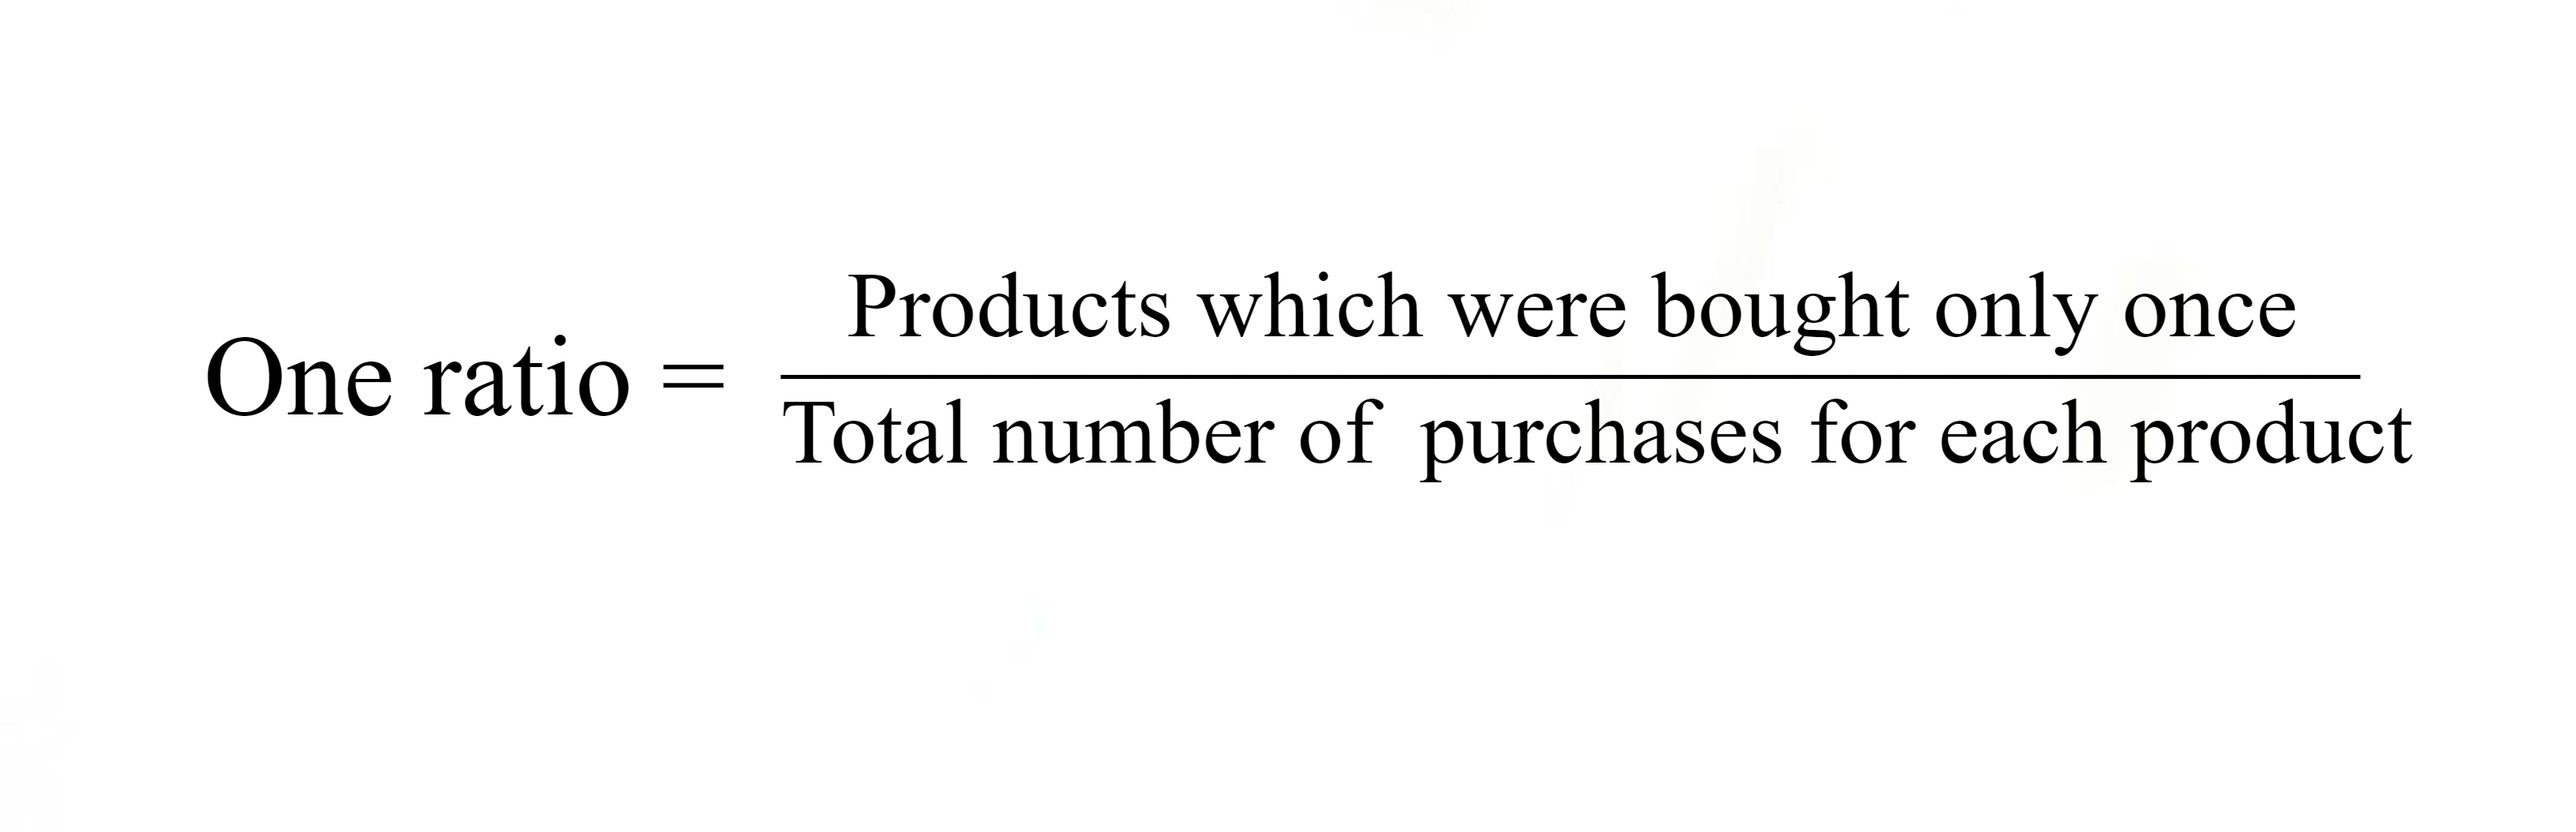

Note: At the beginnig, we will remove the products that have less than 40 purchases in order the calculation of the ratio to be meaningful.

**2.5.1 How many customers bought a product only once?**

In [51]:
# First, we create the op1 DataFrame which has data from the filtered op DataFrame with more than 40 purchases
op1 = op.groupby('product_id').filter(lambda x: x.shape[0] > 40)

In [52]:
pr_cust = op1.groupby(['product_id', 'user_id'])['order_id'].count().to_frame('total')
pr_cust.head()

total
product_id user_id       
1          138          2
           709          1
           764          2
           777          1
           825          1

In [53]:
# The number of users who bought it only once will have 'total == 1'
total_one = pr_cust[pr_cust.total==1]
total_one.head()

total
product_id user_id       
1          709          1
           777          1
           825          1
           910          1
           1379         1

In [54]:
# Customers_only_once 
total_one = total_one.groupby('product_id')['total'].count().to_frame('customers_only_once')
total_one.head()

,customers_only_once
product_id,
1,440
2,70
3,38
4,118
8,52


> For instance, the product with id 1 has been purchased only one time from 440 customers in total.

**2.5.2 Total purchases**

We are going to find the total number of customers who purchased each product.

In [55]:
pr_cust = pr_cust.reset_index()
customers = pr_cust.groupby('product_id')['user_id'].count().to_frame('total_customers')
customers.head()

,total_customers
product_id,
1,716
2,78
3,74
4,182
8,82


> For instance, the product with id 4 has been purchased from 182 users in total.

In [56]:
# Merge the results
results = pd.merge(total_one, customers, on='product_id', how='right')
results.head()

,customers_only_once,total_customers
product_id,,
1,440,716
2,70,78
3,38,74
4,118,182
8,52,82


**2.5.3 One_ratio Variable**

We are going to create the variable one_ratio which is going to show us, if users do reorder a product frequently.

In [57]:
results['one_ratio'] = results['customers_only_once']/results['total_customers']
results.head(10)

,customers_only_once,total_customers,one_ratio
product_id,,,
1,440,716,0.614525
2,70,78,0.897436
3,38,74,0.513514
4,118,182,0.648352
8,52,82,0.634146
9,43,74,0.581081
10,869,1268,0.685331
11,30,45,0.666667
12,82,120,0.683333


>**Note**
> 
* **The higher the variable one_ratio, the lower is the chance for the product to be reordered**.
> 
* **The lower the variable one_ratio, the higher is the chance for the product to be purchased again.**

In [58]:
one = results['one_ratio']
one.head()

product_id
1    0.614525
2    0.897436
3    0.513514
4    0.648352
8    0.634146
Name: one_ratio, dtype: float64

# 2.6 The creation of data Dataframe
All the information from the DataFrames that we have created to store our features (op, user, prd etc.) is now stored on data.

In [59]:
# Merge of data with total_one DataFrame
data = data.merge(one, on='product_id', how='left')
data.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio,mean_add_to_cart_order,one_ratio
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,1.400000,0.417500
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,3.333333,0.447038
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,5.000000,0.478419
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,3.300000,0.470518
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,6.333333,0.520218


In [60]:
# Delete DataFrames
del op, mco, total_one, pr_cust, results, customers, one, op1
gc.collect()

176

# 3. Create train and test DataFrames

**3.1 Include information about the last order of each user**

The data DataFrame (chapter 2.6) should include two more columns which define the type of user (train or test) and the order_id of the future order. This information can be found on the initial orders DataFrame which was provided by Instacart:

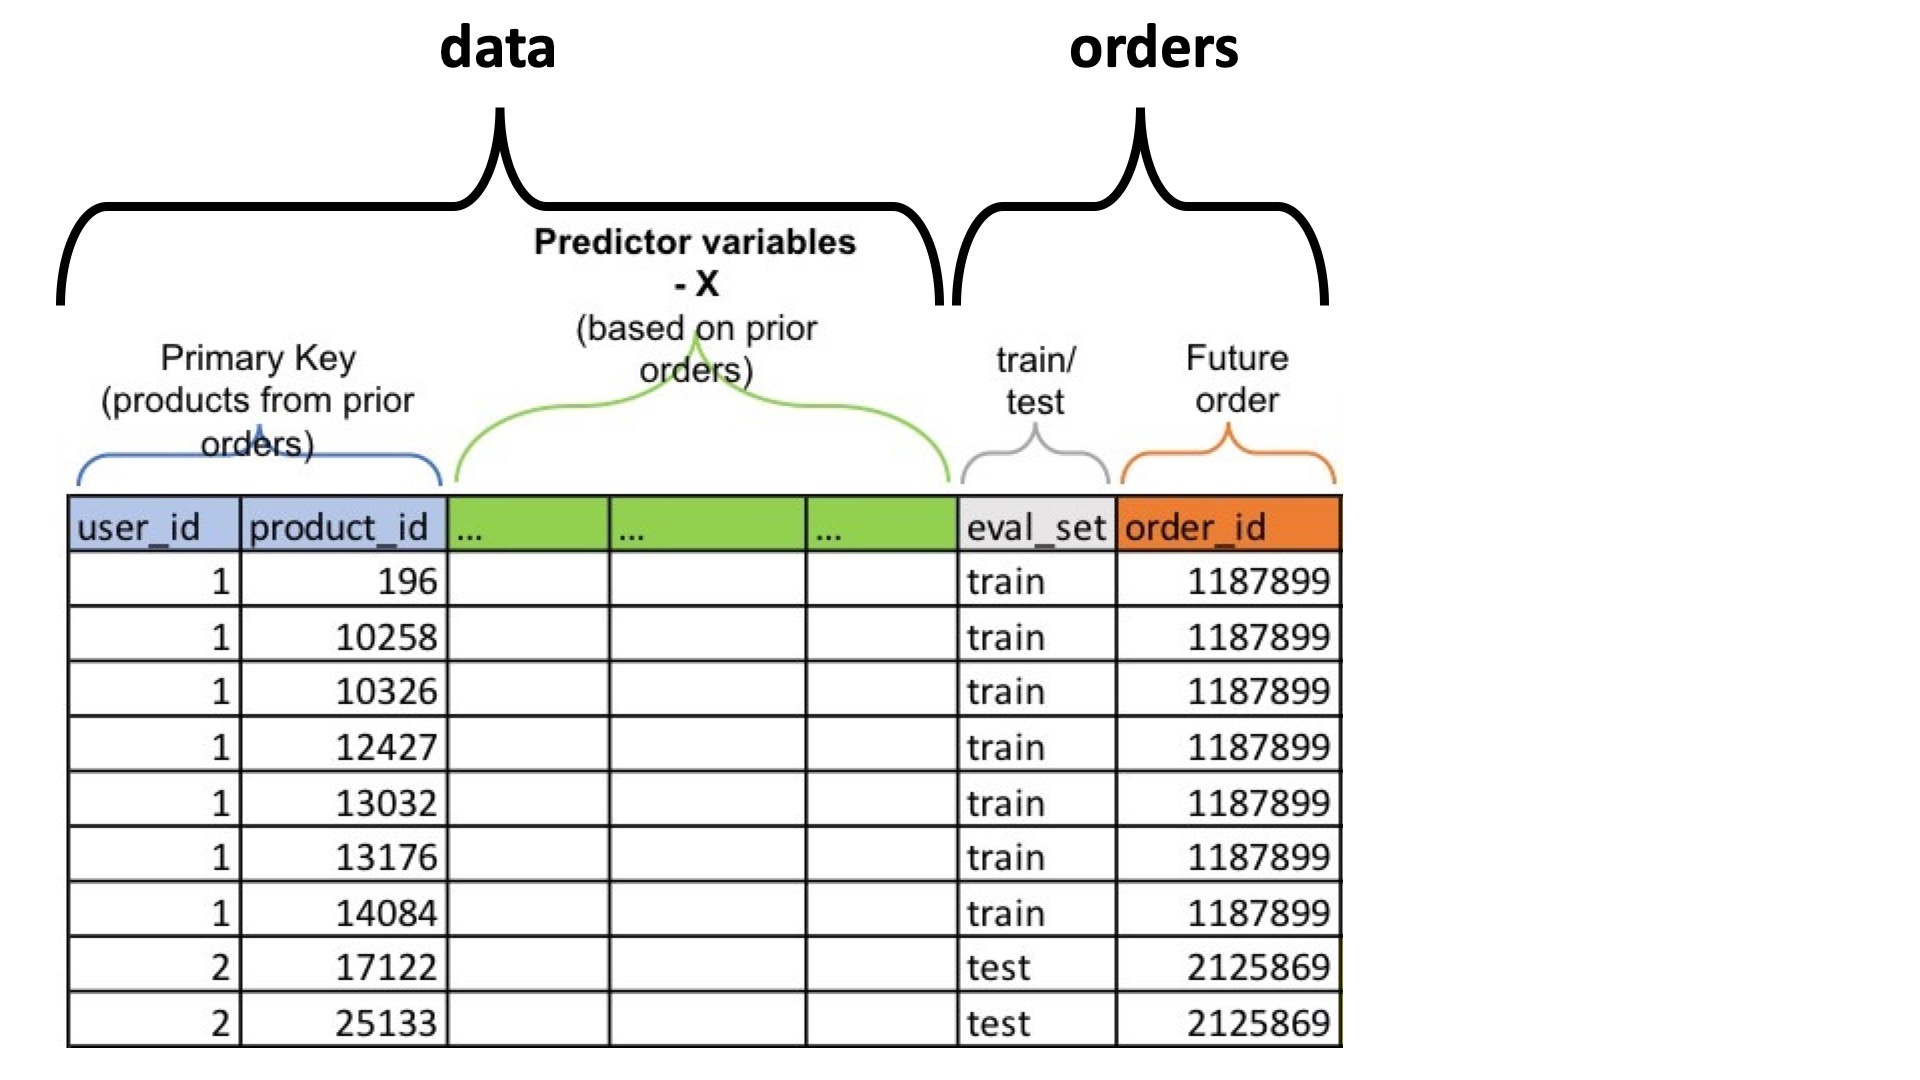

Towards this end:

1. We select the orders DataFrame to keep only the future orders (labeled as "train" & "test).
2. Keep only the columns of our desire ['eval_set', 'order_id'] **AND** 'user_id' as is the matching key with our data DataFrame
3. Merge data DataFrame with the information for the future order of each customer using as matching key the 'user_id'

In [61]:
# Keep only the future orders from all customers: train & test 
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [62]:
# Merge on data DataFrame - Bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio,mean_add_to_cart_order,one_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,1.400000,0.417500,train,1187899
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,3.333333,0.447038,train,1187899
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,5.000000,0.478419,train,1187899
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,3.300000,0.470518,train,1187899
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,6.333333,0.520218,train,1187899


# 3.2 Prepare the train DataFrame

In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

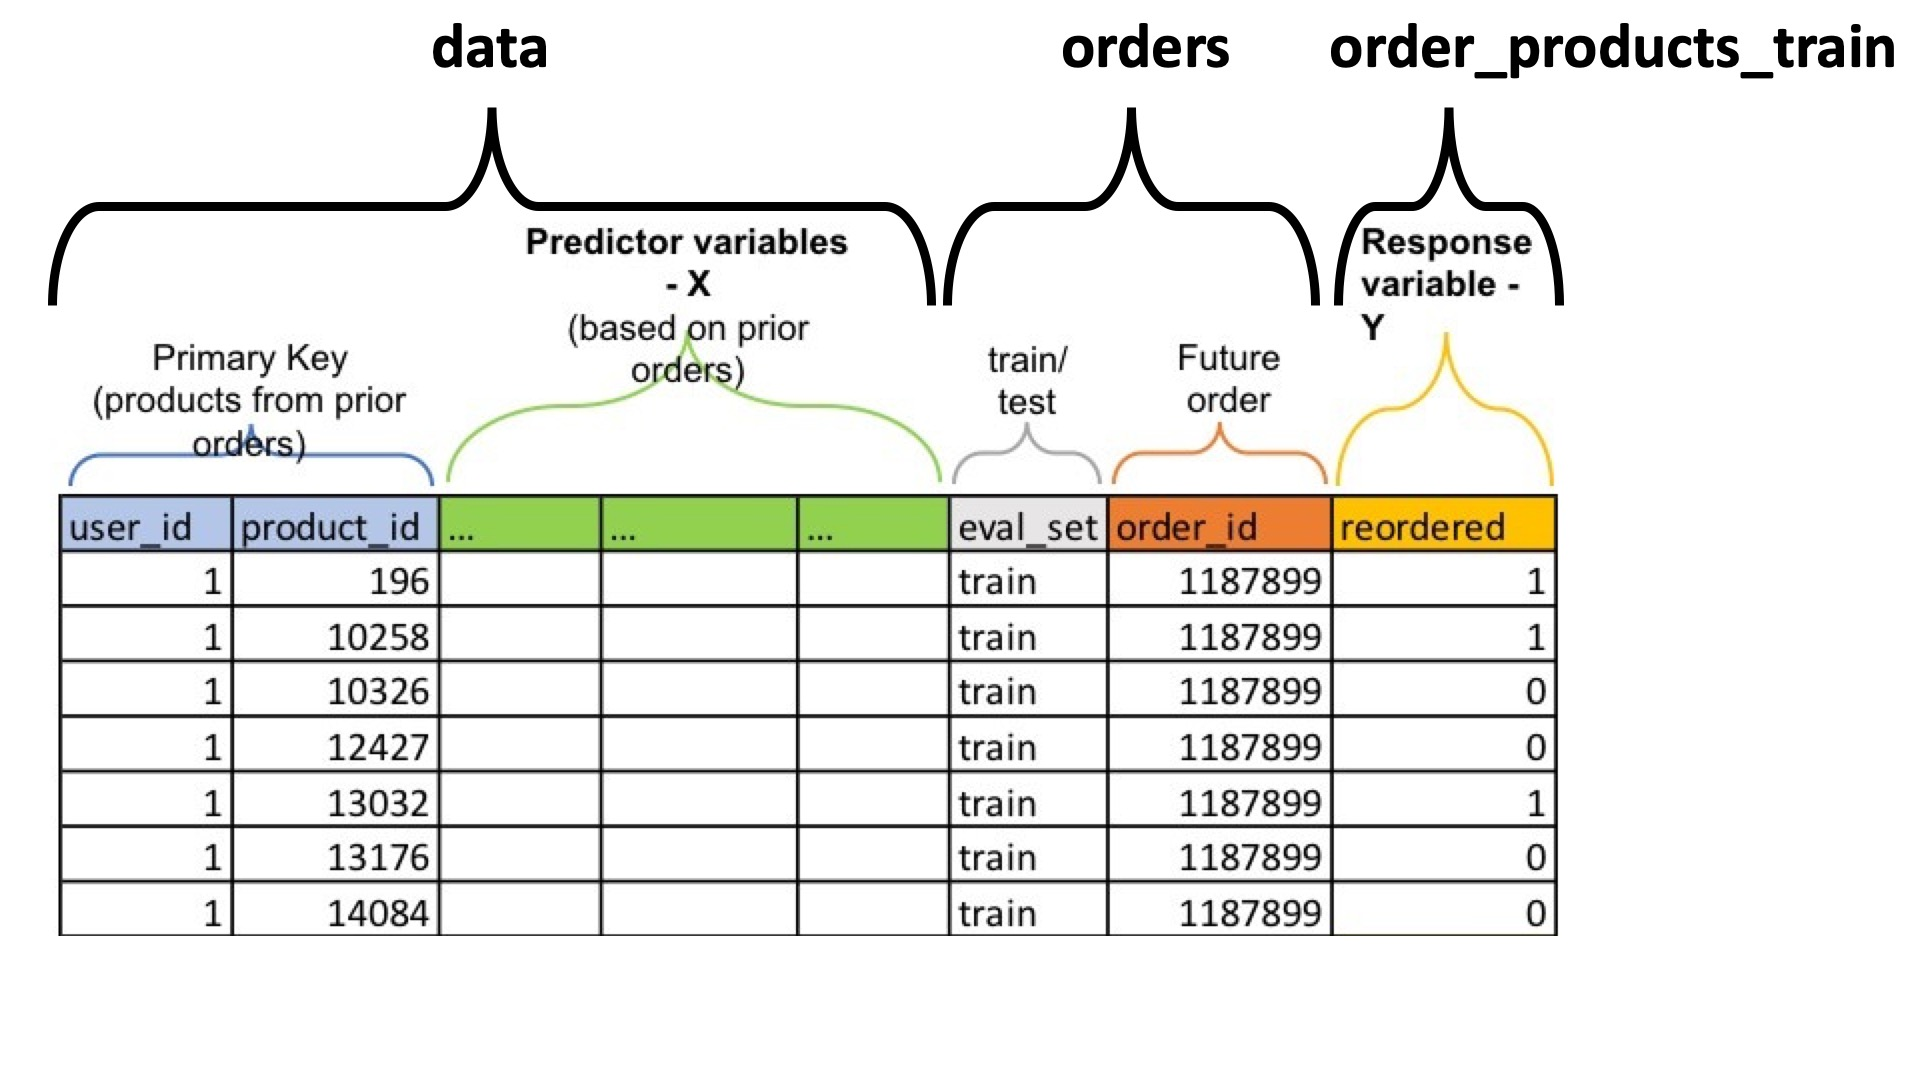

Towards this end:

1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the data DataFrame so to keep only the train users:

In [63]:
# Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio,mean_add_to_cart_order,one_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,1.400000,0.417500,train,1187899
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,3.333333,0.447038,train,1187899
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,5.000000,0.478419,train,1187899
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,3.300000,0.470518,train,1187899
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,6.333333,0.520218,train,1187899


In [64]:
# Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left')
data_train.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio,mean_add_to_cart_order,one_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,1.400000,0.417500,train,1187899,1.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,3.333333,0.447038,train,1187899,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,5.000000,0.478419,train,1187899,NaN
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,3.300000,0.470518,train,1187899,NaN
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,6.333333,0.520218,train,1187899,1.0


In [65]:
# Fill the NaN values of 'reordered' column
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head()

,user_id,product_id,usxpr_total_bought,usxpr_reorder_ratio,last5_times,user_total_orders,user_reordered_ratio,product_total_purchases,product_reorder_ratio,mean_add_to_cart_order,one_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,1.400000,0.417500,train,1187899,1.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,3.333333,0.447038,train,1187899,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,5.000000,0.478419,train,1187899,0.0
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,3.300000,0.470518,train,1187899,0.0
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,6.333333,0.520218,train,1187899,1.0


In [66]:
# Set as index the column(s) that describe uniquely each row 
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head()

usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
user_id product_id                                                         
1       196                         10             1.000000          5.0   
        10258                        9             1.000000          5.0   
        10326                        1             0.166667          0.0   
        12427                       10             1.000000          5.0   
        13032                        3             0.333333          2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
1       196                        10              0.694915   
        10258                      10              0.694915   
        10326                      10              0.694915   
        12427                      10              0.694915   
        13032                      10              0.694915   

                    product_total_purchases  product_reorder_ratio  \
user_id product_id                                                   
1       196                           35791               0.776480   
        10258                          1946               0.713772   
        10326                          5526               0.652009   
        12427                          6476               0.740735   
        13032                          3751               0.657158   

                    mean_add_to_cart_order  one_ratio eval_set  order_id  \
user_id product_id                                                         
1       196                       1.400000   0.417500    train   1187899   
        10258                     3.333333   0.447038    train   1187899   
        10326                     5.000000   0.478419    train   1187899   
        12427                     3.300000   0.470518    train   1187899   
        13032                     6.333333   0.520218    train   1187899   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0  
        12427             0.0  
        13032             1.0

In [67]:
# Remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head()

usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
user_id product_id                                                         
1       196                         10             1.000000          5.0   
        10258                        9             1.000000          5.0   
        10326                        1             0.166667          0.0   
        12427                       10             1.000000          5.0   
        13032                        3             0.333333          2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
1       196                        10              0.694915   
        10258                      10              0.694915   
        10326                      10              0.694915   
        12427                      10              0.694915   
        13032                      10              0.694915   

                    product_total_purchases  product_reorder_ratio  \
user_id product_id                                                   
1       196                           35791               0.776480   
        10258                          1946               0.713772   
        10326                          5526               0.652009   
        12427                          6476               0.740735   
        13032                          3751               0.657158   

                    mean_add_to_cart_order  one_ratio  reordered  
user_id product_id                                                
1       196                       1.400000   0.417500        1.0  
        10258                     3.333333   0.447038        1.0  
        10326                     5.000000   0.478419        0.0  
        12427                     3.300000   0.470518        0.0  
        13032                     6.333333   0.520218        1.0

# 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column as it is the label that we want to predict.
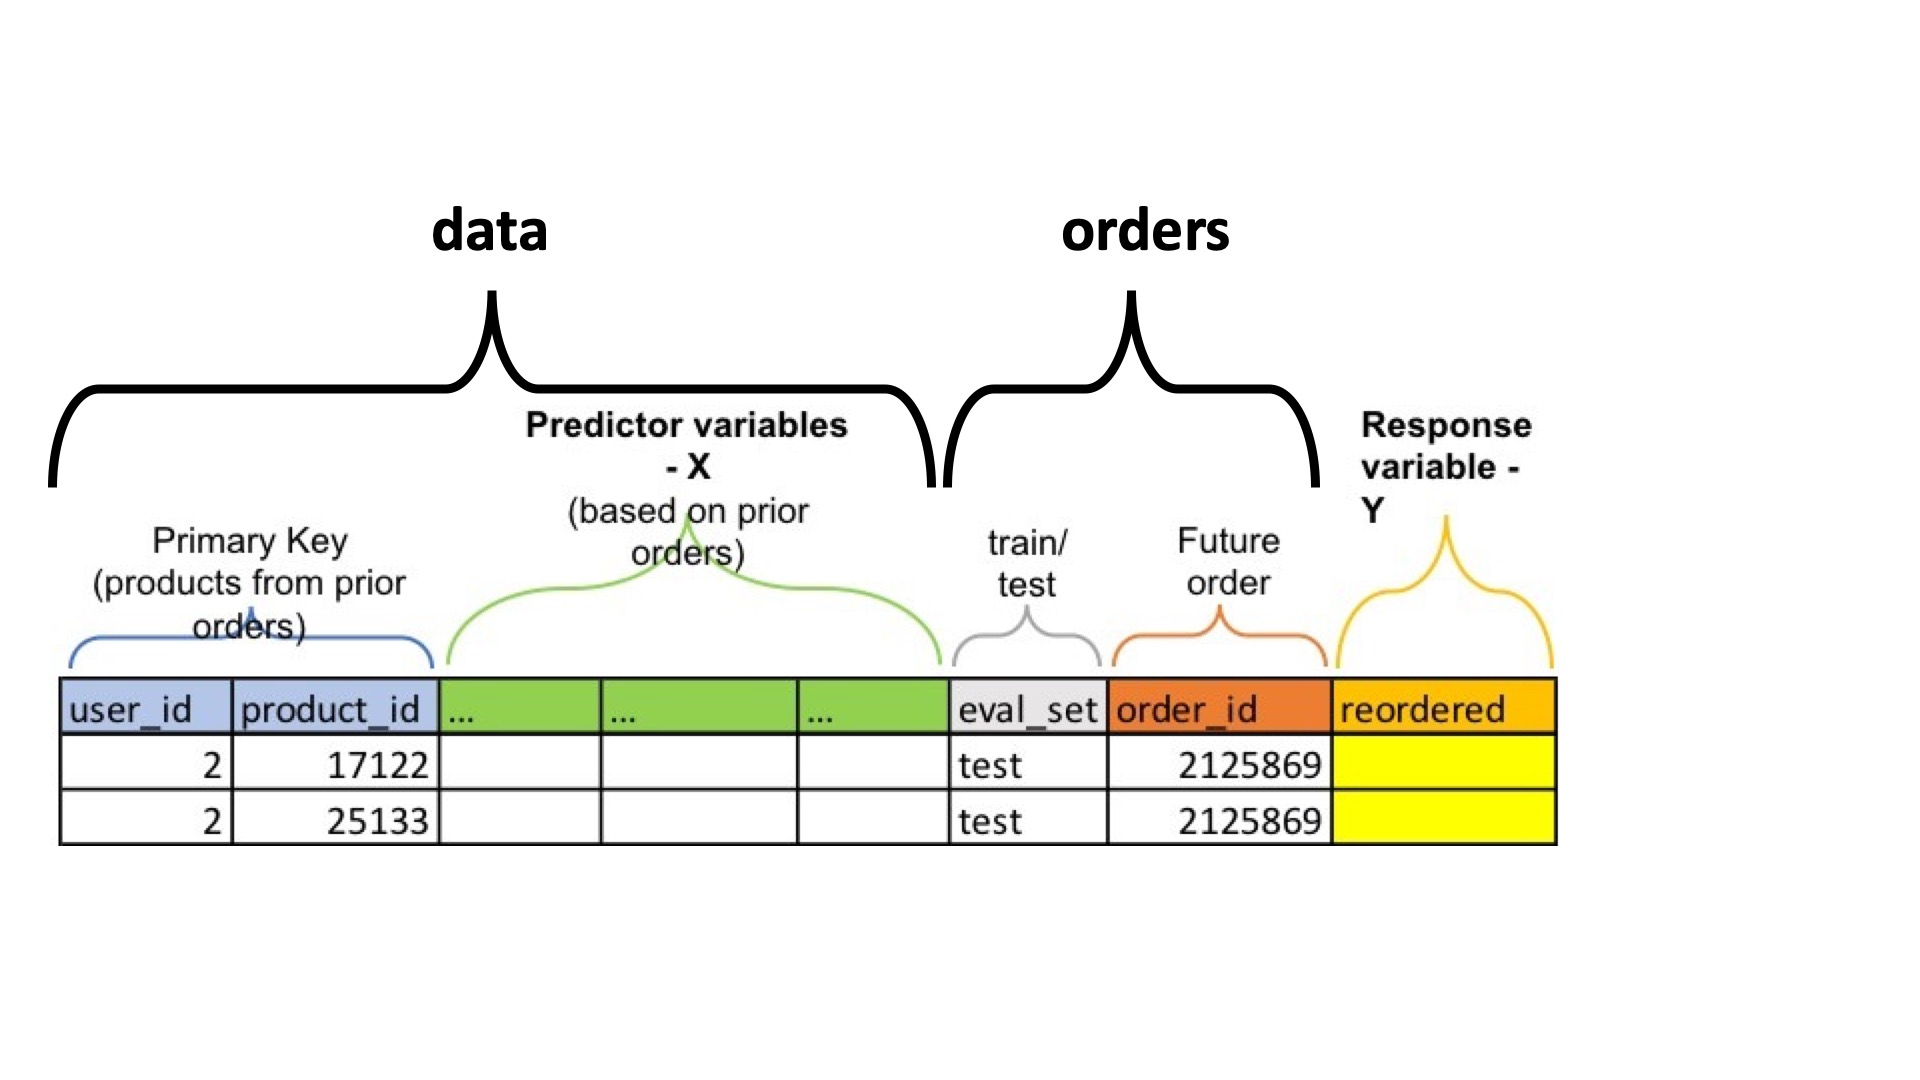

To create it, we:
* Keep only the customers who are labelled as test
* Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")
* Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [68]:
# Keep only the customers who are labelled as test
data_test = data[data.eval_set=='test']

In [69]:
# Set as index the columns that describe each row ("user_id" & "product_id")
data_test = data_test.set_index(['user_id', 'product_id'])

In [70]:
# Remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
data_test.head()

usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
user_id product_id                                                         
3       248                          1             0.090909          0.0   
        1005                         1             0.333333          1.0   
        1819                         3             0.333333          0.0   
        7503                         1             0.100000          0.0   
        8021                         1             0.090909          0.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
3       248                        12                 0.625   
        1005                       12                 0.625   
        1819                       12                 0.625   
        7503                       12                 0.625   
        8021                       12                 0.625   

                    product_total_purchases  product_reorder_ratio  \
user_id product_id                                                   
3       248                            6371               0.400251   
        1005                            463               0.440605   
        1819                           2424               0.492162   
        7503                          12474               0.553551   
        8021                          27864               0.591157   

                    mean_add_to_cart_order  one_ratio  
user_id product_id                                     
3       248                       3.000000   0.720492  
        1005                      5.000000   0.687259  
        1819                      2.666667   0.653128  
        7503                      6.000000   0.616269  
        8021                      5.000000   0.559164

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.

# 4.1 Train XGBoost
XGBoost stands for **eXtreme Gradient Boosting,** an algorithm that is used in many winning solutions for Kaggle competitions [(ref.)](https://github.com/dmlc/xgboost/blob/aa0d8f20c14107481722b45471287c01109c26d2/demo/README.md)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [71]:
import xgboost as xgb
X, y = data_train.drop('reordered', axis=1), data_train.reordered

We split the datasets in train and test sets in order to ensure that the evaluation of the model is unbiased. We tune the model using the train set and then we evaluate the final model in the test set. We hold 25% of the data for the test set.

IMPORTANT: We split Kaggle's Train Set into train (75%) and test sets (25%).

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

We initially create and finetune the model using the train set. In order to ensure that our model will have low variance and bias we employ repeated k-fold Cross-Validation. Cross-validation (CV) is a popular strategy for algorithm selection. The main idea behind CV is to split data, once or several times, for estimating the risk of each algorithm. Part of data (the training sample) is used for training each algorithm, and the remaining part (the validation sample) is used for estimating the risk of the algorithm. We create stratified folds when performing cross-validation. This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross-validation evaluation. We perform 5-fold validation, meaning that we create and evaluate 5 models in each round and the final score is the average score of these models

IMPORTANT: We employ GPU by setting: tree_method='gpu_hist', gpu_id=0

In [73]:
paramGrid = {"learning_rate":[0.1], "n_estimators":[600], "max_depth": [5, 6], "subsample": [0.8], "colsample_bytree": [0.6], "colsample_bylevel": [0.6]}  

model = XGBClassifier(nthread=10, tree_method='gpu_hist', gpu_id=0)

cv = StratifiedKFold()

gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)

fit = gridsearch.fit(X_train, y_train)

print(fit.best_score_)

print(fit.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:20] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  42.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:57] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  38.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:36] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  39.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:15] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  40.0s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:55] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  39.1s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:34] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  44.2s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  45.1s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  44.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:48] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  45.0s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:25:33] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  44.7s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8289530076790346
{'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8}


In [74]:
fit.score(X_test, y_test)

0.8291567404978771

In [75]:
best = fit.best_estimator_

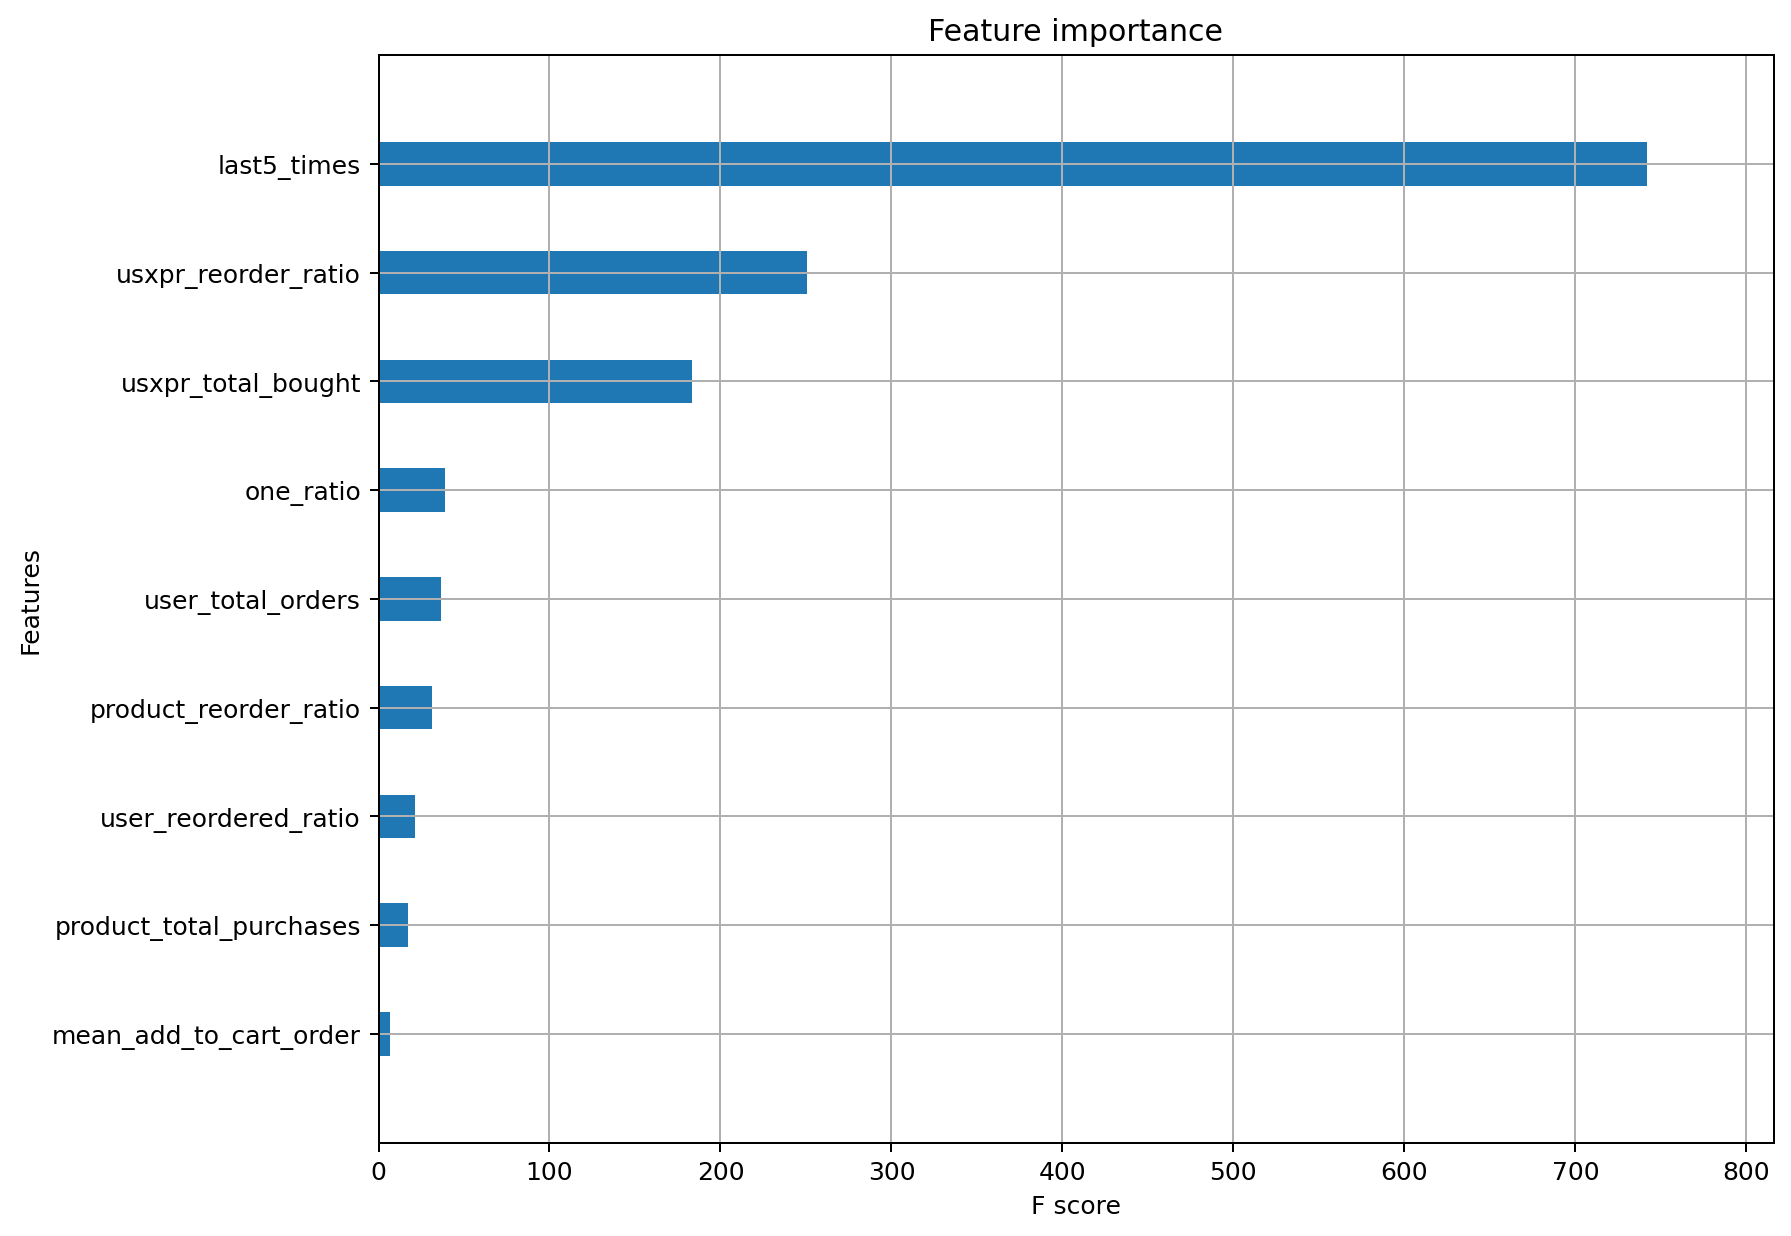

In [77]:
# Matplotlip inline
fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)
plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)
pyplot.show()